In [1]:
!nvidia-smi

Mon Aug 24 08:05:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import copy
import time

In [3]:
train_transform = transforms.Compose([ transforms.RandomCrop(32, padding=4),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.4247, 0.4150, 0.3840], [0.2827, 0.2777, 0.2844])]) #Calculated using https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.4942, 0.4851, 0.4504], [0.2467, 0.2429, 0.2616])]) 

trainset = torchvision.datasets.CIFAR10(root='/content/data', train=True, download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='/content/data', train=False, download=True, transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=16)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True, num_workers=16)

dataset_sizes = {'train':len(trainset), 'val':len(testset)}
dataloaders = {'train':trainloader, 'val':testloader}

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Extracting /content/data/cifar-10-python.tar.gz to /content/data
Files already downloaded and verified


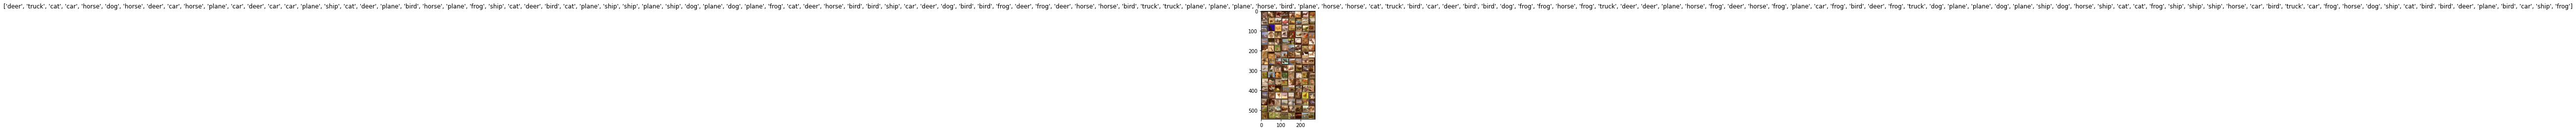

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5570, 0.4385, 0.3198])
    std = np.array([0.2581, 0.2615, 0.2630])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings
warnings.simplefilter("ignore")

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        since = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            time_elapsed = time.time() - since
            print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))            
            
            torch.save(model.state_dict(), '/content/food101_efnetb2_' + str(epoch+1) + '.pth')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} || actual: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [16]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.AdamW(model.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [17]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=30)

Epoch 1/30
----------
train Loss: 0.9362 Acc: 0.6746
Training complete in 0m 29s
val Loss: 0.8293 Acc: 0.7162
Training complete in 0m 32s

Epoch 2/30
----------
train Loss: 0.7453 Acc: 0.7420
Training complete in 0m 29s
val Loss: 0.6828 Acc: 0.7667
Training complete in 0m 32s

Epoch 3/30
----------
train Loss: 0.6468 Acc: 0.7737
Training complete in 0m 29s
val Loss: 0.5979 Acc: 0.7975
Training complete in 0m 32s

Epoch 4/30
----------
train Loss: 0.5818 Acc: 0.7977
Training complete in 0m 29s
val Loss: 0.6017 Acc: 0.7963
Training complete in 0m 32s

Epoch 5/30
----------
train Loss: 0.5376 Acc: 0.8133
Training complete in 0m 30s
val Loss: 0.5621 Acc: 0.8048
Training complete in 0m 33s

Epoch 6/30
----------
train Loss: 0.5069 Acc: 0.8227
Training complete in 0m 29s
val Loss: 0.5457 Acc: 0.8125
Training complete in 0m 32s

Epoch 7/30
----------
train Loss: 0.4731 Acc: 0.8321
Training complete in 0m 29s
val Loss: 0.5475 Acc: 0.8153
Training complete in 0m 33s

Epoch 8/30
----------
train

In [ ]:
  visualize_model(model)